In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

Load the data 

In [2]:
df=pd.read_csv('./Data_project/bengaluru_house_prices.csv')
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.shape

(13320, 9)

Check the columns one by one

In [4]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

In [5]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

Drop the unimportant columns

In [6]:
df2=df.drop(['area_type','availability','society','balcony'],axis=1)
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


# Data Cleaning

In [7]:
# Hundling missing value
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
# Fill the bath null values by median 

In [9]:
df2['bath'].median()

np.float64(2.0)

In [10]:
import math
bath_median=math.floor(df2['bath'].median())

In [11]:
df2['bath']=df2['bath'].fillna(bath_median)

In [12]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath           0
price          0
dtype: int64

Drop the remain null values

In [13]:
df3=df2.dropna()

In [14]:
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [15]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [16]:
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [17]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13303 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13303 non-null  object 
 1   size        13303 non-null  object 
 2   total_sqft  13303 non-null  object 
 3   bath        13303 non-null  float64
 4   price       13303 non-null  float64
dtypes: float64(2), object(3)
memory usage: 623.6+ KB


In [18]:
df3['BHK']=df3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\R.C\AppData\Local\Temp\ipykernel_13228\1156995945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['BHK']=df3['size'].apply(lambda x: int(x.split(' ')[0]))


In [19]:
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [20]:
df3['BHK']

0        2
1        4
2        3
3        3
4        2
        ..
13315    5
13316    4
13317    2
13318    4
13319    1
Name: BHK, Length: 13303, dtype: int64

In [21]:
df3['BHK'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [22]:
df3[df3['BHK']==43]

,location,size,total_sqft,bath,price,BHK
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [23]:
df3[df3['BHK']>20]

,location,size,total_sqft,bath,price,BHK
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [24]:
df3[df3['BHK']<20]

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00,5
13316,Richards Town,4 BHK,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00,4


Next Columns

In [25]:
df3['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2110,), dtype=object)

In [26]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13303 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13303 non-null  object 
 1   size        13303 non-null  object 
 2   total_sqft  13303 non-null  object 
 3   bath        13303 non-null  float64
 4   price       13303 non-null  float64
 5   BHK         13303 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 727.5+ KB


Make a function that convert the values in sqft to float by try and except method

In [27]:
def is_float(x):
    try:
         float(x)
    
    except:
        return False
    return True

#this function chk that if we can convert the x into float 
#try method helps to convert the x into float 
#if the value is in string try method help to convert it into the float 
#if the value is not converted into the float it execute in except method or it return the false 



In [28]:
df3.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [29]:
#Apply the function
df3[df3['total_sqft'].apply(is_float)]
#it will the true value like float converting value 

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00,5
13316,Richards Town,4 BHK,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00,2
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00,4


In [30]:
#but i want to see thoes values who's not converted into float so use ~ this is a negate function 
df3[~df3['total_sqft'].apply(is_float)]

,location,size,total_sqft,bath,price,BHK
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
...,...,...,...,...,...,...
12990,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13240,Devanahalli,1 BHK,1020 - 1130,2.0,52.570,1
13265,Hoodi,2 BHK,1133 - 1384,2.0,59.135,2


In [31]:
def convert_sqft_to_num(x):
    tokens=x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[1])/2)
    try:
        return float(x)
    except:
        return None


In [32]:
convert_sqft_to_num("1521")

1521.0

In [33]:
df4=df3.copy()

In [34]:
df4.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [35]:
df4['total_sqft']=df4['total_sqft'].apply(convert_sqft_to_num)

In [36]:
df4.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [37]:
df4.tail()

,location,size,total_sqft,bath,price,BHK
13315,Whitefield,5 Bedroom,3453.0,4.0,231.0,5
13316,Richards Town,4 BHK,3600.0,5.0,400.0,4
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.0,2
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.0,4
13319,Doddathoguru,1 BHK,550.0,1.0,17.0,1


In [38]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       3525.0
bath                4.0
price             186.0
BHK                   4
Name: 30, dtype: object

Feature Engineering 

In [41]:
df5=df4.copy()

In [42]:
df5.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [43]:
df5['Price_Per_Sqft']=df5['price']*100000/df5['total_sqft']

In [44]:
df5.head()

,location,size,total_sqft,bath,price,BHK,Price_Per_Sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [45]:
df5['location'].value_counts()

location
Whitefield                         539
Sarjapur  Road                     397
Electronic City                    302
Kanakpura Road                     273
Thanisandra                        234
                                  ... 
KAMAKIYA                             1
Wheelers Road                        1
MM Layout                            1
Devarabeesana Halli                  1
beml layout, basaveshwara nagar      1
Name: count, Length: 1304, dtype: int64

In [46]:
df5.groupby('location')['location'].agg('count')

location
 Anekal                 1
 Banaswadi              1
 Basavangudi            1
 Bhoganhalli            1
 Devarabeesana Halli    6
                       ..
t.c palya               1
tc.palya                4
vinayakanagar           1
white field,kadugodi    1
whitefiled              1
Name: location, Length: 1304, dtype: int64

In [47]:
len(df5['location'])

13303

clean the whitespaces ' jp nagar '

In [49]:
df5['location']=df5['location'].apply(lambda x: x.strip())

In [51]:
df5['location'].head()

0    Electronic City Phase II
1            Chikka Tirupathi
2                 Uttarahalli
3          Lingadheeranahalli
4                    Kothanur
Name: location, dtype: object

In [52]:
len(df5['location'])

13303

In [53]:
df5['location'].value_counts()

location
Whitefield                              540
Sarjapur  Road                          397
Electronic City                         304
Kanakpura Road                          273
Thanisandra                             237
                                       ... 
Duddanahalli                              1
Doddanakunte                              1
Jogupalya                                 1
Subhash Nagar                             1
Kengeri Satellite Town KHB Apartment      1
Name: count, Length: 1293, dtype: int64

In [54]:
location_stat=df5['location'].value_counts().sort_index(ascending=False)

In [56]:
location_stat.head()

location
whitefiled              1
white field,kadugodi    1
vinayakanagar           1
tc.palya                4
t.c palya               1
Name: count, dtype: int64

In [59]:
len(location_stat[location_stat<=10])

1052

In [60]:
location_stat_less_then_10=location_stat[location_stat<=10]

In [62]:
len(location_stat_less_then_10)

1052

In [64]:
len(df5['location'].unique())

1293

In [65]:
df5['location']=df5['location'].apply(lambda x: 'other' if x in location_stat_less_then_10 else x)

In [66]:
df5['location'].head()

0    Electronic City Phase II
1            Chikka Tirupathi
2                 Uttarahalli
3          Lingadheeranahalli
4                    Kothanur
Name: location, dtype: object

In [68]:
len(df5['location'].unique())

242

In [74]:
df5['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli',
       'Lingadheeranahalli', 'Kothanur', 'Whitefield', 'Old Airport Road',
       'Rajaji Nagar', 'Marathahalli', 'other', '7th Phase JP Nagar',
       'Gottigere', 'Sarjapur', 'Mysore Road', 'Bisuvanahalli',
       'Raja Rajeshwari Nagar', 'Kengeri', 'Binny Pete', 'Thanisandra',
       'Bellandur', 'Electronic City', 'Ramagondanahalli', 'Yelahanka',
       'Hebbal', 'Kasturi Nagar', 'Kanakpura Road',
       'Electronics City Phase 1', 'Kundalahalli', 'Chikkalasandra',
       'Murugeshpalya', 'Sarjapur  Road', 'HSR Layout', 'Doddathoguru',
       'KR Puram', 'Bhoganhalli', 'Lakshminarayana Pura', 'Begur Road',
       'Devanahalli', 'Varthur', 'Bommanahalli', 'Gunjur',
       'Devarachikkanahalli', 'Hegde Nagar', 'Haralur Road',
       'Hennur Road', 'Kothannur', 'Kalena Agrahara', 'Kaval Byrasandra',
       'ISRO Layout', 'Garudachar Palya', 'EPIP Zone', 'Dasanapura',
       'Kasavanhalli', 'Sanjay nagar', 'Domlur',


In [70]:
df5.head()

,location,size,total_sqft,bath,price,BHK,Price_Per_Sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [71]:
df6=df5[~(df5['total_sqft']/df5['BHK']<300)]

In [72]:
df6.head()

,location,size,total_sqft,bath,price,BHK,Price_Per_Sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [73]:
len(df6['location'])

12559

In [75]:
def remove_pps_outlier(df):
    df_out=pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m=np.mean(subdf.Price_Per_Sqft)
        st=np.std(subdf.Price_Per_Sqft)
        reduced_df=subdf[(subdf.Price_Per_Sqft>(m-st )) & (subdf.Price_Per_Sqft<=(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out


In [76]:
df7=remove_pps_outlier(df6)

In [77]:
df7.head()

,location,size,total_sqft,bath,price,BHK,Price_Per_Sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [80]:
df7.shape

(10268, 7)

In [83]:
def remove_bhk_outlier(df):
    exclude_indices=np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats={}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk]={
                'mean':np.mean(bhk_df.Price_Per_Sqft),
                'std':np.std(bhk_df.Price_Per_Sqft),
                'count':bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats=bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices,bhk_df[bhk_df.Price_Per_Sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8=remove_bhk_outlier(df7)
df8.shape


(7339, 7)

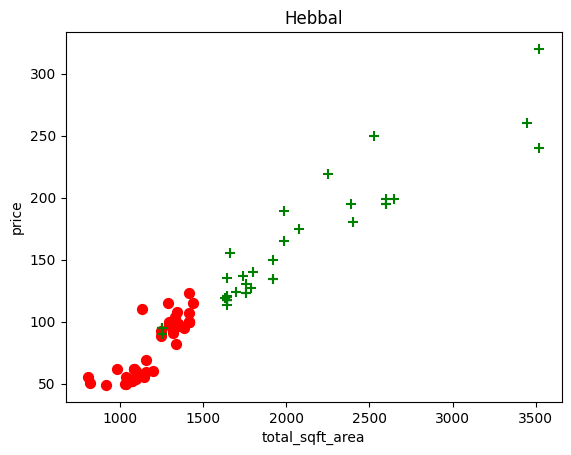

In [90]:
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location) & (df.BHK==2)]
    bhk3=df[(df.location==location) & (df.BHK==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price,color='red',label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,label='3 BHK',color="green",s=50,marker='+')
    plt.xlabel('total_sqft_area')
    plt.ylabel('price')
    plt.title(location)
plot_scatter_chart(df8,'Hebbal')


(array([1.126e+03, 5.727e+03, 2.466e+03, 4.940e+02, 2.630e+02, 1.260e+02,
        3.900e+01, 1.700e+01, 5.000e+00, 5.000e+00]),
 array([ 1250.        ,  3575.98039216,  5901.96078431,  8227.94117647,
        10553.92156863, 12879.90196078, 15205.88235294, 17531.8627451 ,
        19857.84313725, 22183.82352941, 24509.80392157]),
 <BarContainer object of 10 artists>)

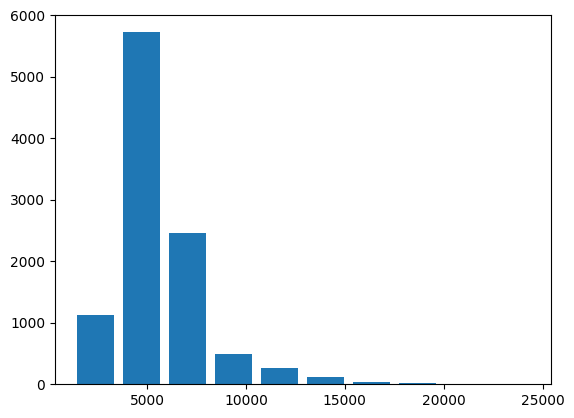

In [91]:
plt.hist(df7['Price_Per_Sqft'],rwidth=0.8)

In [92]:
df8['bath'].unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

(array([4.791e+03, 1.761e+03, 6.710e+02, 7.600e+01, 2.800e+01, 7.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)

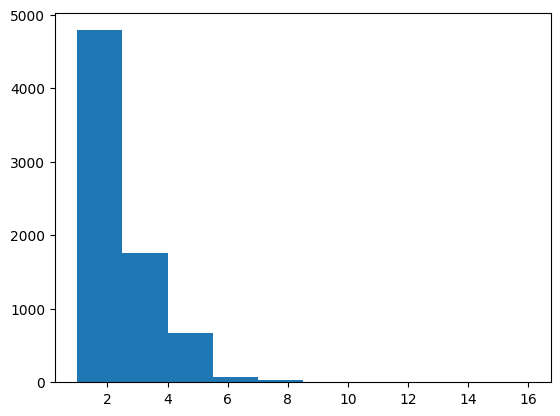

In [95]:
plt.hist(df8['bath'])

In [96]:
df9=df8.drop(['Price_Per_Sqft','size'],axis=1)

In [97]:
df9

,location,total_sqft,bath,price,BHK
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
...,...,...,...,...,...
10259,other,1200.0,2.0,70.0,2
10260,other,1800.0,1.0,200.0,1
10263,other,1353.0,2.0,110.0,2
10264,other,812.0,1.0,26.0,1


In [98]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7339 entries, 0 to 10267
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7339 non-null   object 
 1   total_sqft  7339 non-null   float64
 2   bath        7339 non-null   float64
 3   price       7339 non-null   float64
 4   BHK         7339 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 344.0+ KB


In [101]:
dummies=pd.get_dummies(df9['location'])

In [148]:
df10=pd.concat([df9,dummies.drop('other',axis=1)],axis=1)

In [149]:
df10.head()

,location,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [151]:
df11=df10.drop('location',axis=1)

In [152]:
df11.head()

,total_sqft,bath,price,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,235.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,130.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,148.0,2,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [153]:
x=df11.drop('price',axis=1)

In [154]:
x

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259,1200.0,2.0,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10260,1800.0,1.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10263,1353.0,2.0,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10264,812.0,1.0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [165]:
x=x.astype(int)

In [166]:
x

,total_sqft,bath,BHK,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850,4,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630,3,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875,2,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200,2,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235,2,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10259,1200,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10260,1800,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10263,1353,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10264,812,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
y=df11['price']

In [168]:
y

0        428.0
1        194.0
2        235.0
3        130.0
4        148.0
         ...  
10259     70.0
10260    200.0
10263    110.0
10264     26.0
10267    400.0
Name: price, Length: 7339, dtype: float64

In [169]:
from sklearn.model_selection import train_test_split

In [170]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=10)

In [171]:
len(x_train)

5871

In [172]:
len(x_test)

1468

In [164]:
print(x.dtypes)

total_sqft             float64
bath                   float64
BHK                      int64
1st Block Jayanagar       bool
1st Phase JP Nagar        bool
                        ...   
Yelachenahalli            bool
Yelahanka                 bool
Yelahanka New Town        bool
Yelenahalli               bool
Yeshwanthpur              bool
Length: 244, dtype: object


In [173]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [174]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=10)
cross_val_score(LinearRegression(),x,y,cv=cv)

array([0.77974291, 0.83075432, 0.82301624, 0.85258273, 0.80008062])

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
def find_best_model_using_grid